<a href="https://colab.research.google.com/github/callumselv/Y4_project/blob/main/NN_QST_Torlai_et_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as pl
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt

In [3]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        self.weights = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.hidden_bias = nn.Parameter(torch.zeros(n_hidden))
        self.visible_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_hidden(self, visible_prob):
        hidden_activation = torch.sigmoid(F.linear(visible_prob, self.weights, self.hidden_bias))
        hidden_sample = torch.bernoulli(hidden_activation)
        return hidden_sample

    def sample_visible(self, hidden_prob):
        visible_activation = torch.sigmoid(F.linear(hidden_prob, self.weights.t(), self.visible_bias))
        visible_sample = torch.bernoulli(visible_activation)
        return visible_sample

    def forward(self, v):
        hidden_prob = self.sample_hidden(v)
        visible_reconstructed = self.sample_visible(hidden_prob)
        return visible_reconstructed


In [4]:
def generate_data(n_samples, n_qubits):
    data = []
    for _ in range(n_samples):
        state = np.zeros(n_qubits)
        state[np.random.randint(0, n_qubits)] = 1
        data.append(state)
    return torch.Tensor(data)

In [6]:
def count_ones(data):
    n_samples, n_qubits = data.size()
    counter = torch.zeros(n_qubits)

    for sample in data:
        index = torch.argmax(sample)
        counter[index] += 1

    return counter

In [7]:
def prob_ones(data):
    n_samples, n_qubits = data.size()
    counts = count_ones(data)
    return counts / n_samples

In [8]:
samp_1000 = generate_data(1000,20)
dist_1000 = count_ones(samp_1000)
prob_1000 = prob_ones(samp_1000)

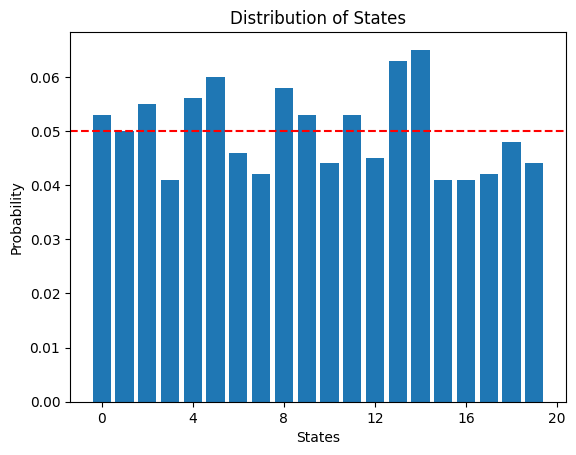

In [9]:
plt.bar(np.arange(20), prob_1000)
plt.axhline(1/len(prob_1000), linestyle='--', color='red')
plt.xlabel("States")
plt.ylabel("Probability")
plt.title("Distribution of States")
plt.xticks(np.arange(0,24,4))
plt.show()

In [11]:
Ns = [60, 1000, 10000]
st_d = {}
prob_d = {}

for n in Ns:
    samp = generate_data(n,20)
    st_d[n] = count_ones(samp)
    prob_d[n] = prob_ones(samp)

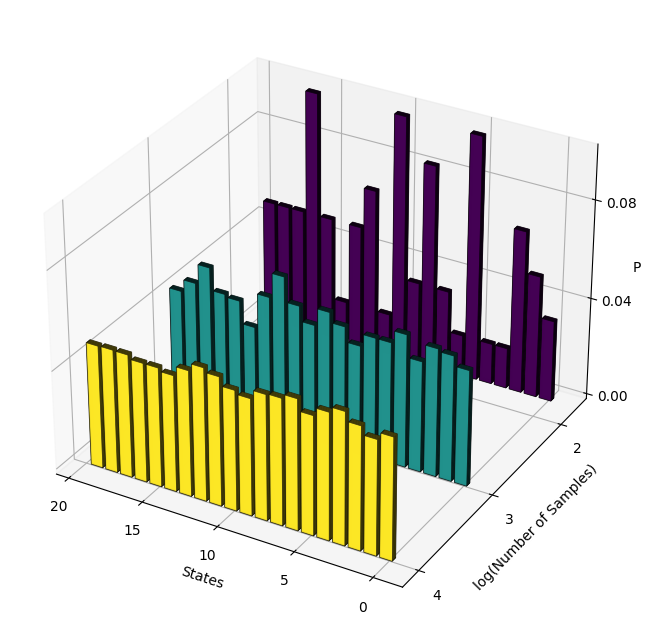

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot( projection="3d")
x_positions = np.arange(20)

colors = plt.cm.viridis(np.linspace(0, 1, len(Ns)))

for idx, n in enumerate(Ns):
    for i in range(10):
      dz = 0.005
      ax.bar(x_positions, prob_d[n], zs=np.log10(n)+(i*dz), zdir='y', alpha=0.8,
           width=0.8, color=colors[idx], edgecolor='k', linewidth=0.5)

ax.set_xlabel("States")
ax.set_ylabel("log(Number of Samples)")
ax.set_zlabel("P", labelpad=-1)
ax.set_xticks(x_positions)

ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])

ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=5))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=5))
ax.zaxis.set_major_locator(plt.MaxNLocator(nbins=3))

In [10]:
def train_rbm(rbm, data, epochs=10, lr=0.01):
    optimizer = optim.SGD(rbm.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0
        for sample in data:
            sample_v = Variable(sample)
            sample_reconstructed = rbm(sample_v)
            loss = torch.sum((sample_v - sample_reconstructed) ** 2)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(data)}")


n_visible = 20
n_hidden = 20
n_samples = 10000

rbm = RBM(n_visible=n_visible, n_hidden=n_hidden)

training_data = generate_data(n_samples=n_samples, n_qubits=n_visible)

train_rbm(rbm, training_data)


Epoch 1 Loss: 9.7438
Epoch 2 Loss: 9.7631
Epoch 3 Loss: 9.7602
Epoch 4 Loss: 9.7882
Epoch 5 Loss: 9.7927
Epoch 6 Loss: 9.7937
Epoch 7 Loss: 9.802
Epoch 8 Loss: 9.7408
Epoch 9 Loss: 9.7852
Epoch 10 Loss: 9.7705


In [25]:
def evaluate_rbm(rbm, test_data):
    matches = 0
    for sample in test_data:
        sample_v = Variable(sample)
        reconstructed_sample = rbm(sample_v)
        if torch.equal(sample_v, torch.round(reconstructed_sample)):
            matches += 1
    accuracy = matches / len(test_data)
    print(f"Reconstruction Accuracy: {accuracy * 100:.2f}%")

In [26]:
evaluate_rbm(rbm, training_data)

Reconstruction Accuracy: 0.00%


In [40]:
def plot_state_distribution(rbm, n_samples, n_qubits):
    samples = []
    for _ in range(n_samples):
        v = torch.bernoulli(torch.rand(n_qubits))
        for _ in range(10):
            v = rbm.sample_visible(rbm.sample_hidden(v))
        samples.append("".join(map(str, v.int().tolist())))

    from collections import Counter
    state_counts = Counter(samples)
    states, counts = zip(*state_counts.items())

    prob = np.array(counts) / n_samples

    # plt.axhline(1/(n_qubits), linestyle='--', color='red', label='Expected Probability')
    plt.bar(states, prob)
    plt.xlabel("States")
    plt.ylabel("Probability")
    plt.title("Distribution of Reconstructed States")
    plt.xticks(rotation=90)
    plt.show()

    return states, prob


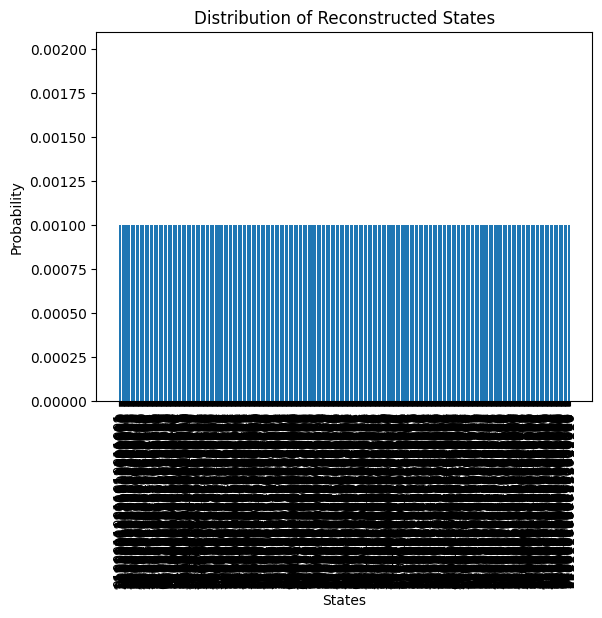

In [41]:
st_1000, prob_1000 = plot_state_distribution(rbm, n_samples=1000, n_qubits=n_visible)

In [129]:
Ns = [60, 1000, 10000]
st_d = {}
prob_d = {}
for n in Ns:
    st_d[n], prob_d[n] = plot_state_distribution(rbm, n_samples=n, n_qubits=n_visible)

len(st_d[60])

16

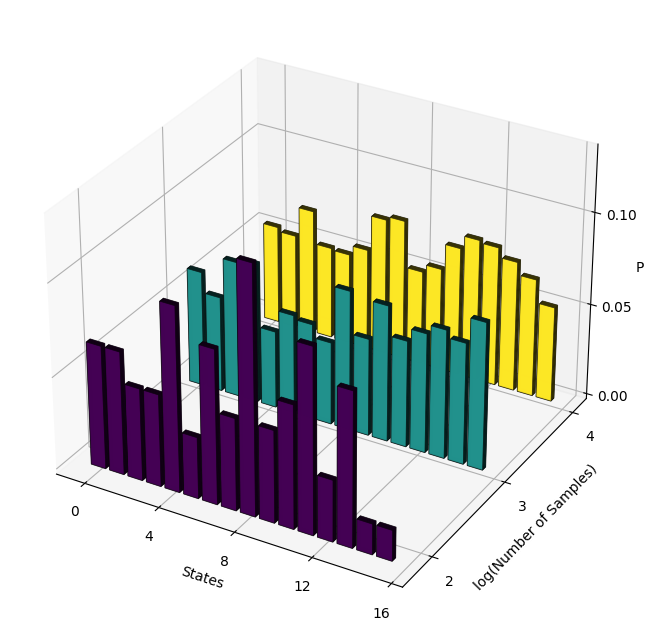

In [130]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
x_positions = np.arange((n_visible)**2)

colors = plt.cm.viridis(np.linspace(0, 1, len(Ns)))

for idx, n in enumerate(Ns):
    for i in range(10):
      dz = 0.005
      ax.bar(x_positions, prob_d[n], zs=np.log10(n)+(i*dz), zdir='y', alpha=0.8,
           width=0.8, color=colors[idx], edgecolor='k', linewidth=0.5)

# ax.set_zscale('log')
ax.set_xlabel("States")
ax.set_ylabel("log(Number of Samples)")
ax.set_zlabel("P", labelpad=0)
ax.set_xticks(x_positions)

ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=5))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=5))
ax.zaxis.set_major_locator(plt.MaxNLocator(nbins=3))

# plt.title("3D Histogram of Reconstructed States vs. Sample Size")
plt.show()

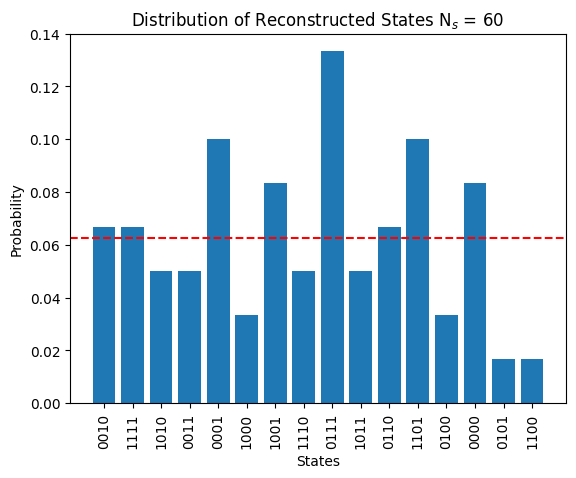

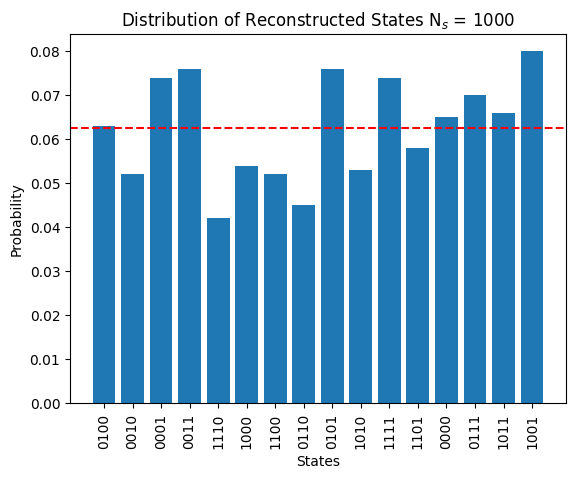

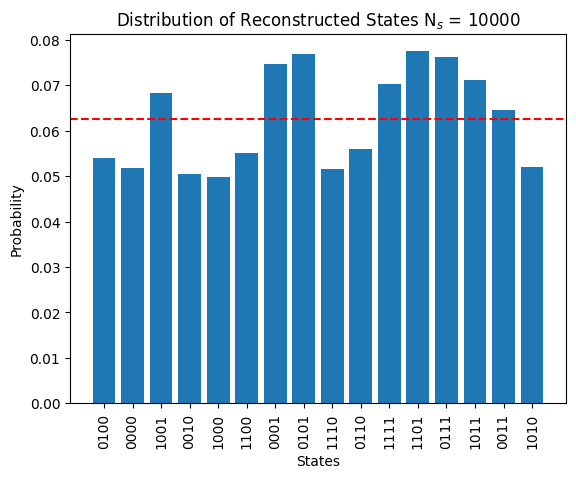

In [131]:
for n in Ns:
  plt.axhline(1/(n_visible**2), linestyle='--', color='red', label='Expected Probability')
  plt.bar(st_d[n], prob_d[n])
  plt.xlabel("States")
  plt.ylabel("Probability")
  plt.title(fr'Distribution of Reconstructed States N$_s$ = {n}')
  plt.xticks(rotation=90)
  plt.show()